In [1]:
%config Completer.use_jedi = False

In [2]:
from regrid import regrid
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pickle
from calendar import monthrange
import mask
import tqdm
import pickle
import cartopy.crs as ccrs
import cartopy
import datetime
import pandas as pd
import itertools
from cartoplot import cartoplot

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [3]:
with Dataset('/media/robbie/Brokendrive/E5/ERA_nh_1973_12.nc') as ERA5_data:
    lons = np.array(ERA5_data['longitude'])
    lats = np.array(ERA5_data['latitude'])
    
ERA5_lon_grid = np.array([np.array(lons), ] * 121)
ERA5_lat_grid = np.array([np.array(lats), ] * 1440).T

conc_dict = pickle.load(open('processors/conc_dict.p','rb'))

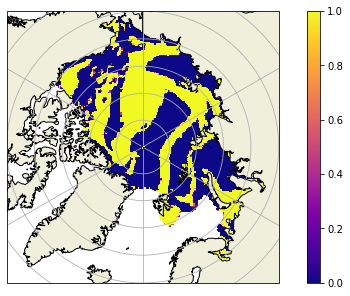

In [4]:
def month_conc_mask(input_array,sic):
        
    m3d = np.repeat(sic[np.newaxis,:,:],input_array.shape[0],axis=0)
    
    output = np.multiply(input_array,m3d)
    
    return(output)
    
year = 2020
month = 2

elons, elats = mask.get('lon'), mask.get('lat')

sic = conc_dict[month][year]

d = Dataset(f'/media/robbie/TOSHIBA EXT/vorticity_files/{year}{str(month).zfill(2)}.nc')

dat = np.array(d['vort_3hr'])

mm = month_conc_mask(dat,sic)

cartoplot(elons,elats,mm[10],color_scale=(0,1))

In [11]:
d

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): hrs(224), x(361), y(361)
    variables(dimensions): float32 vort_3hr(hrs,x,y), float32 lapl_3hr(hrs,x,y), float32 div_3hr(hrs,x,y), float32 div_ave(x,y), float32 vort_ave(x,y), float32 lon(x,y), float32 lat(x,y), int32 hrs_since_1900(hrs)
    groups: 

In [12]:
years = np.arange(1980,2022)
months = [12,1,2] 

list_of_dicts = []

hourly_means = []

for year in tqdm.tqdm(years):

    mean3h = []
    
    for month in months:
        
        get_year = year if month in [1,2] else year-1    
        
        d = Dataset(f'/media/robbie/TOSHIBA EXT/vorticity_files/{get_year}{str(month).zfill(2)}.nc')
        
        vort_field = np.array(d['div_3hr'])
        
        sic = conc_dict[month][get_year]
        
        masked_3d_vort = month_conc_mask(vort_field,sic)
        
#         plt.imshow(vort_field[10])
#         plt.show()
#         plt.imshow(masked_3d_vort[10])
#         plt.show()
        
        ###########################################################################
        
    
        m = np.nanmean(masked_3d_vort, axis=(1,2))
        
        mean3h += list(m)

        list_of_dicts.append({
#                               'mean_vort_basin':mean_vort_basin,
                              'winter_year':year,
                              'year':get_year,
                              'month':month
                             })


    hourly_means.append(mean3h)
        
    
vort_monthly_df = pd.DataFrame(list_of_dicts)

vort_djf_df = vort_monthly_df[vort_monthly_df['month'].isin([12,1,2])]

vort_monthly_df

100%|██████████| 42/42 [03:06<00:00,  4.43s/it]


,winter_year,year,month
0,1980,1979,12
1,1980,1980,1
2,1980,1980,2
3,1981,1980,12
4,1981,1981,1
...,...,...,...
121,2020,2020,1
122,2020,2020,2
123,2021,2020,12
124,2021,2021,1


In [98]:
# pickle.dump(hourly_means,open('figure1/vorts.p','wb'))

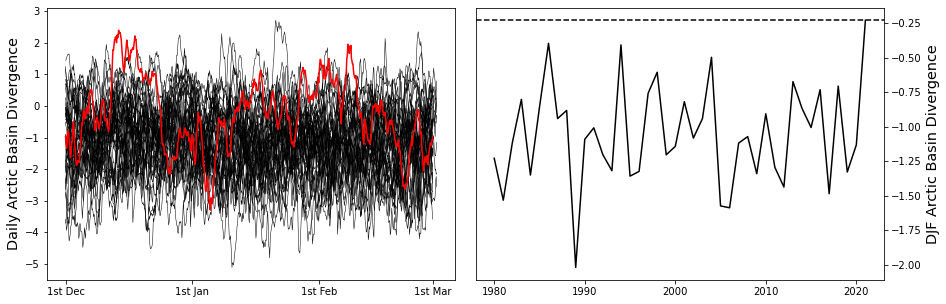

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ann_means = []

for counter, year in enumerate(years):
    
    if year == 2021:
        color = 'r'
        lw=1.5
#     elif year == 1989:
#         color='b'
#         lw=1
    else:
        color = 'k'
        lw=0.5
    
    ax1.plot(hourly_means[counter],color=color,lw=lw)
    
#     if np.isnan(np.mean(hourly_means[counter])):
#         print(hourly_means[counter])
#     elif np.mean(hourly_means[counter]) > 2:
#         print(hourly_means[counter])
        
    ann_means.append(np.mean(hourly_means[counter]))
    
ax2.plot(years,ann_means,color='k')

ax1.set_xticks([0,(31)*8,(31+31)*8,(31+31+28)*8])
ax1.set_xticklabels(['1st Dec', '1st Jan', '1st Feb', '1st Mar'])
ax1.set_ylabel('Daily Arctic Basin Divergence', fontsize='x-large')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.axhline(ann_means[-1], color='k',ls='--')
ax2.set_ylabel('DJF Arctic Basin Divergence', fontsize='x-large')

plt.subplots_adjust(wspace=0.05)

In [5]:
import metpy.calc as mpcalc

In [6]:
vels = pickle.load(open('vels.p','rb'))

In [7]:
ease_lons, ease_lats = mask.get('lon'), mask.get('lat')

ease_dx, ease_dy = mpcalc.lat_lon_grid_deltas(ease_lons, ease_lats)

ease_dx = abs(ease_dx); ease_dy = abs(ease_dy)


In [11]:
divs = {}

for year in tqdm.tqdm(vels.keys()):
    
    div_array = np.full((12,361,361), np.nan)
    
    for i in range(12):

        u0 = vels[year][0][i]
        v0 = vels[year][1][i]

        div = mpcalc.divergence(u0, v0,  dx= ease_dx,dy= ease_dy)

        mdiv = mask.select_region('central arctic',div)
        
        mdiv = abs(mdiv)
        
        div_array[i] = mdiv
        
    divs[year] = div_array

100%|██████████| 42/42 [00:04<00:00,  8.69it/s]


In [12]:
mean_divs = []
for year in tqdm.tqdm(vels.keys()):
    mean_divs.append( np.nanmean(divs[year]))

100%|██████████| 42/42 [00:00<00:00, 123.63it/s]


Text(0, 0.5, 'Mean Abs( Divergence )')

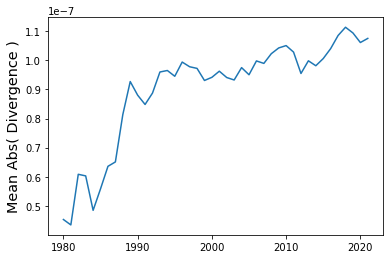

In [15]:
plt.plot(np.arange(1980,2022),mean_divs)
plt.ylabel('Mean Abs( Divergence )', fontsize='x-large')    

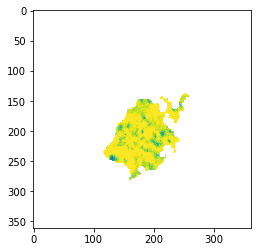

In [51]:
plt.imshow(divs[2010][0])